[ 임소영 ] 의사결정트리, 부스팅

[ 피쳐-(임시) ] 단백질(g),나트륨(mg) ,당류(g), 포화지방(g)

[ 데이터셋 ] 
- 맥도날드 : https://www.kaggle.com/datasets/mcdonalds/nutrition-facts
- 롯데리아 : https://www.lotteeatz.com/upload/stg/etc/ria/items.html
- 미국 전 지점 : https://www.kaggle.com/datasets/ulrikthygepedersen/fastfood-nutrition
- 버거킹 : https://emilysinglelife.tistory.com/62
- 맘스터치(이미지) : https://www.momstouch.co.kr/m/brand/notice-view.php?idx=49
- 노브랜드 : https://realjace.tistory.com/entry/%EB%85%B8%EB%B8%8C%EB%9E%9C%EB%93%9C%EB%B2%84%EA%B1%B0-%EB%A9%94%EB%89%B4%EB%B3%84-%EC%B9%BC%EB%A1%9C%EB%A6%AC-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84-%EC%B4%9D%EC%A0%95%EB%A6%AC
- 프랭크 버거 : https://rooftoper.tistory.com/entry/%ED%94%84%EB%9E%AD%ED%81%AC-%EB%B2%84%EA%B1%B0-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84

## 자료 준비, 전처리 (결측치, 중복값, 이상치)

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [71]:
file = './Hamburger.csv'
data = pd.read_csv(file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1068 non-null   object 
 1   item        1068 non-null   object 
 2   calories    1068 non-null   float64
 3   sodium      1068 non-null   float64
 4   sugar       1068 non-null   float64
 5   total_fat   1068 non-null   float64
 6   protein     1068 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.5+ KB


In [72]:
data.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [73]:
data.duplicated().sum()

2

In [74]:
data

,restaurant,item,calories,sodium,sugar,total_fat,protein
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380.00,1110.00,11.00,7.00,37.00
1,Mcdonalds,Single Bacon Smokehouse Burger,840.00,1580.00,18.00,45.00,46.00
2,Mcdonalds,Double Bacon Smokehouse Burger,1130.00,1920.00,18.00,67.00,70.00
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750.00,1940.00,18.00,31.00,55.00
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920.00,1980.00,18.00,45.00,46.00
...,...,...,...,...,...,...,...
1063,prank_burger,더블치즈버거(L),687.04,4.55,33.45,19.51,1149.60
1064,prank_burger,머쉬룸버거(L),665.30,13.58,26.75,18.10,1203.43
1065,prank_burger,JG버거(L),828.28,6.42,48.23,22.28,1574.77
1066,prank_burger,SG불고기버거(L),491.06,13.84,17.24,10.60,606.15


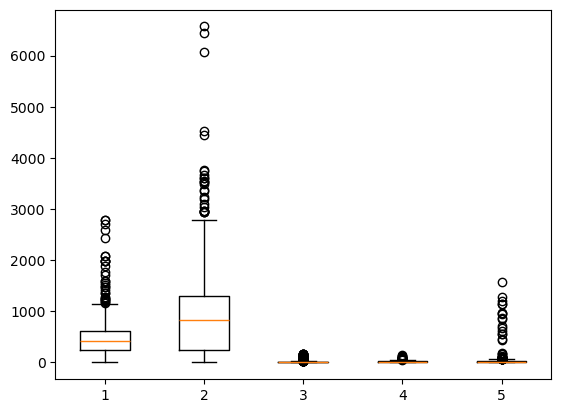

In [75]:
plt.boxplot(data[['calories','sodium','sugar','total_fat','protein']])
plt.show()

In [76]:
def print_flier(insert_data):
    q1 = insert_data.quantile(0.25)
    q3 = insert_data.quantile(0.75)
    iqr = q3 - q1
    #print(f"[ q1 ] \n{q1}\n\n[ q3 ] \n{q3}\n")
    #print(f"[ iqr의 범위 ]\n{iqr}\n")

    print('------------------ 이상값이 될 기준 계산 ------------------\n')

    lower = q1 - 1.5 * iqr
    #print(f"[ lower의 값 ]\n{lower}\n")
    upper = q3 + 1.5 * iqr
    #print(f"[ upper의 값 ]\n{upper}\n")

    mask = insert_data < lower
    print(f"[ lower의 개수 ]\n{mask.sum()}\n")
    mask2 = insert_data > upper
    print(f"[ upper의 개수 ]\n{mask2.sum()}\n")

    return lower, upper

lower, upper = print_flier(data[['calories','sodium','sugar','total_fat','protein']])

------------------ 이상값이 될 기준 계산 ------------------

[ lower의 개수 ]
calories     0
sodium       0
sugar        0
total_fat    0
protein      0
dtype: int64

[ upper의 개수 ]
calories      31
sodium        26
sugar        150
total_fat     33
protein       45
dtype: int64


In [77]:
data[['calories','sodium','sugar','total_fat','protein']].shape

(1068, 5)

In [78]:
def drop_flier(insert_data, col_name):
    global lower
    global upper
    print(f"이상치 제거 전 shape 확인: {insert_data.shape}")
    mask = insert_data[col_name] >= lower.loc[col_name]
    insert_data = insert_data[mask]
    #print(f" '{col_name}' 컬럼에서 lower 미만의 값 제거 후 shape: {insert_data.shape}")

    mask2 = insert_data[col_name] <= upper.loc[col_name]
    insert_data = insert_data[mask2]
    #print(f" '{col_name}' 컬럼에서 upper 초과의 값 제거 후 shape: {insert_data.shape}\n")
    
    print(f"이상치 제거 후 shape 확인: {insert_data.shape} \n")
    return insert_data

data_for_drop = data[['calories','sodium','sugar','total_fat','protein']]
# data_for_drop = drop_flier(data_for_drop, 'calories')
# data_for_drop = drop_flier(data_for_drop, 'sodium')
# data_for_drop = drop_flier(data_for_drop, 'sugar')
# data_for_drop = drop_flier(data_for_drop, 'total_fat')
# data_for_drop = drop_flier(data_for_drop, 'protein')


# 이상치 제거한 데이터에 맞게 원본 데이터도 제거된 인덱스 번호를 같이 drop 시켜줌
# for i in list(data.index):
#     if i not in (list(data_for_drop.index)):
#         data.drop(i,inplace = True)
# print(data.shape)
# 
# # 인덱스 번호가 서로 일치하는지 확인
# print(len(list(data_for_drop.index)) == len(list(data.index)))
# # 서로 일치하는 것을 확인 했으니 이 데이터를 이용해서 알고리즘 돌리겠다.

이상치를 제거했더니 과대 적합이 계속 나왔다. 이상치를 다시 복구 했더니 과대적합이 덜나와서 이상치를 다시 복구했다.

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1068 non-null   object 
 1   item        1068 non-null   object 
 2   calories    1068 non-null   float64
 3   sodium      1068 non-null   float64
 4   sugar       1068 non-null   float64
 5   total_fat   1068 non-null   float64
 6   protein     1068 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.5+ KB


## 데이터셋 분리 & 스케일링 & 학습 & 평가

In [80]:
data.corr(numeric_only=True)

,calories,sodium,sugar,total_fat,protein
calories,1.000000,0.811985,0.305116,0.723007,0.172215
sodium,0.811985,1.000000,-0.096722,0.706815,0.005060
sugar,0.305116,-0.096722,1.000000,-0.055567,0.065918
total_fat,0.723007,0.706815,-0.055567,1.000000,0.093055
protein,0.172215,0.005060,0.065918,0.093055,1.000000


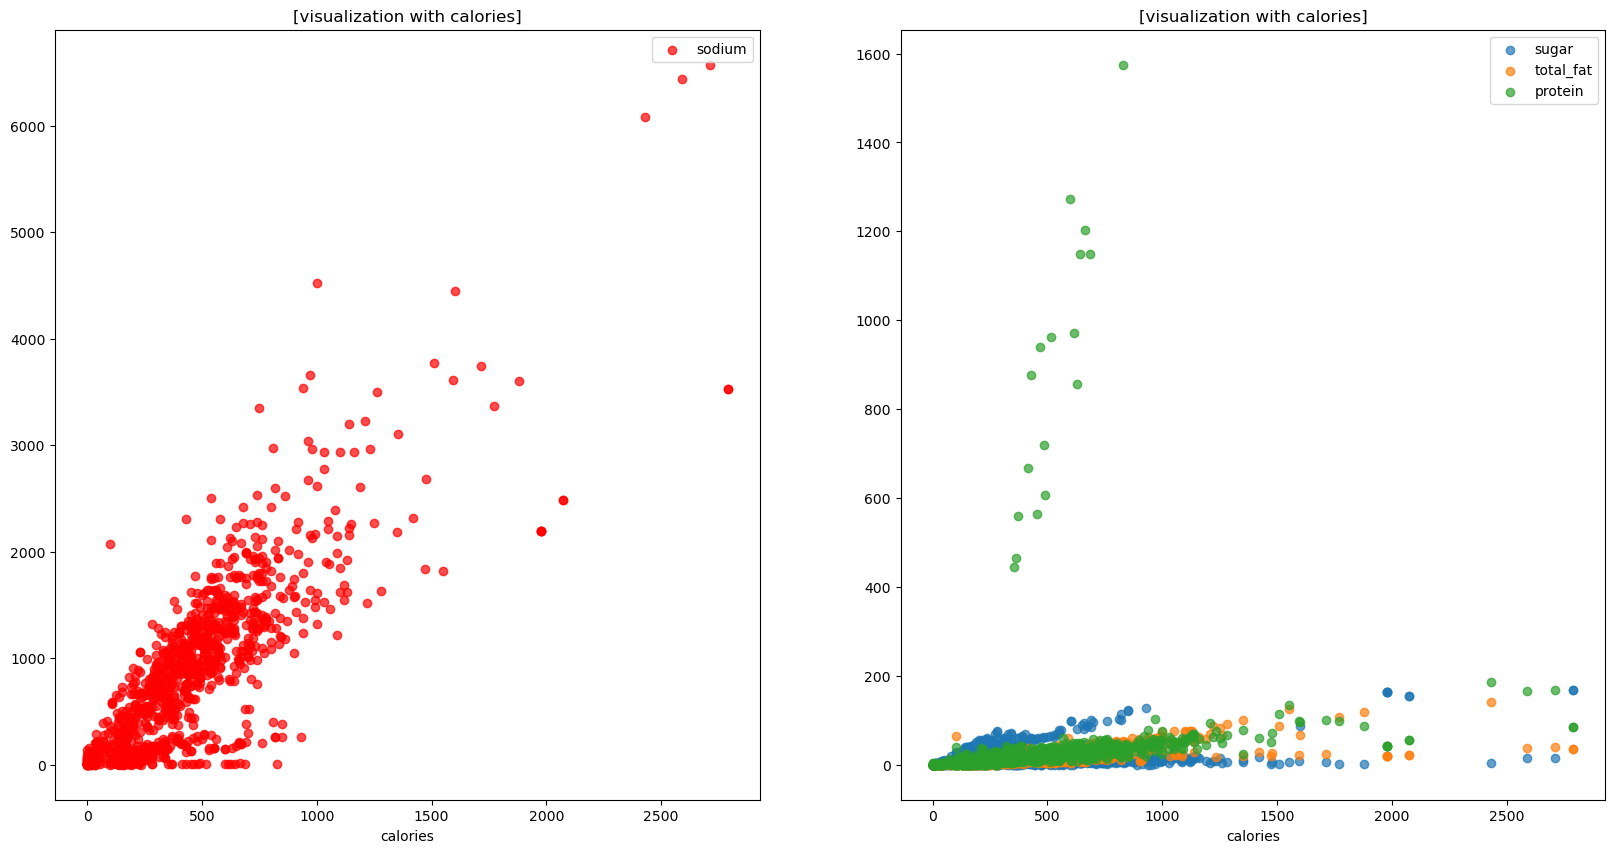

In [81]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(data['calories'], data['sodium'], label = 'sodium', c = 'red', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")

plt.subplot(1,2,2)
plt.scatter(data['calories'], data['sugar'], label = 'sugar', alpha = 0.7)
plt.scatter(data['calories'], data['total_fat'], label = 'total_fat', alpha = 0.7)
plt.scatter(data['calories'], data['protein'], label = 'protein', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")
plt.show()

In [82]:
target = data['calories']
feature = data[['sodium','sugar','total_fat','protein']]

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
train_score_list = []
test_score_list = []

# 최고의 random_state 값 찾기
'''
for number in range(1,1001):
    X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = number)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_X_train = scaler.transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(scaled_X_train, columns = ['sodium', 'sugar', 'total_fat', 'protein'])
    X_test = pd.DataFrame(scaled_X_test, columns = ['sodium', 'sugar', 'total_fat', 'protein']) 
    
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    #print(f"{number} => [train score] {train_score}      [test_score] {test_score}")
    
max_score = max(test_score_list)
for i in range(len(test_score_list)):
    if test_score_list[i] == max_score:
        print(f"최고의 random_state 값은 {i+1}")
        best_random = i+1
        '''        
# 425

'\nfor number in range(1,1001):\n    X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = number)\n    \n    scaler = StandardScaler()\n    scaler.fit(X_train)\n    scaled_X_train = scaler.transform(X_train)\n    scaled_X_test = scaler.transform(X_test)\n    X_train = pd.DataFrame(scaled_X_train, columns = [\'sodium\', \'sugar\', \'total_fat\', \'protein\'])\n    X_test = pd.DataFrame(scaled_X_test, columns = [\'sodium\', \'sugar\', \'total_fat\', \'protein\']) \n    \n    model = DecisionTreeRegressor()\n    model.fit(X_train, y_train)\n    \n    train_score = model.score(X_train, y_train)\n    test_score = model.score(X_test, y_test)\n    train_score_list.append(train_score)\n    test_score_list.append(test_score)\n    #print(f"{number} => [train score] {train_score}      [test_score] {test_score}")\n    \nmax_score = max(test_score_list)\nfor i in range(len(test_score_list)):\n    if test_score_list[i] == max_score:\n        print(f"최고의 random_state 값은

## 튜닝 전

In [84]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 425)

scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
X_train = pd.DataFrame(scaled_X_train, columns = ['sodium', 'sugar', 'total_fat', 'protein'])
X_test = pd.DataFrame(scaled_X_test, columns = ['sodium', 'sugar', 'total_fat', 'protein']) 

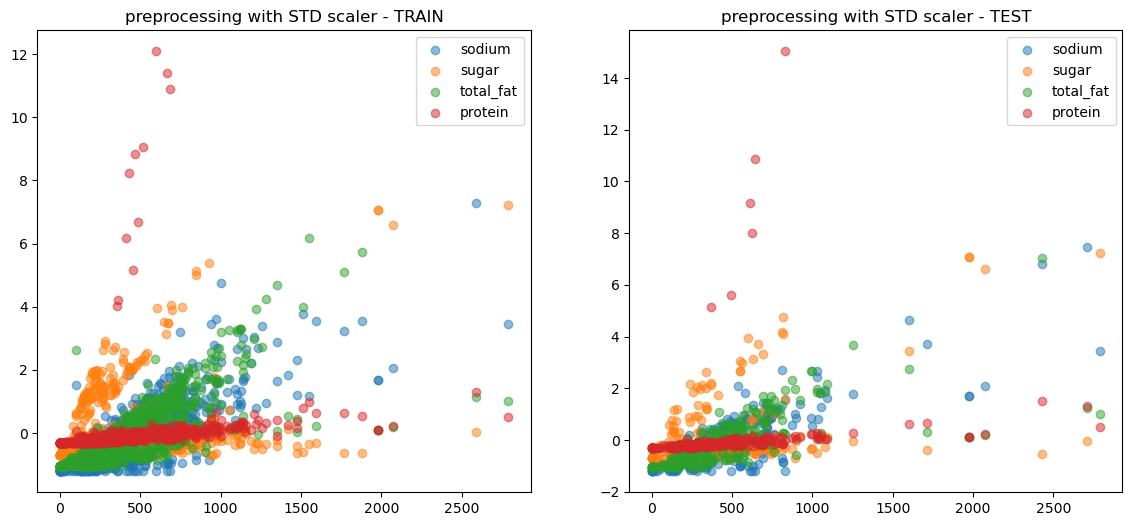

In [85]:
# 스케일링이 잘 되었는지 확인해보자

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TRAIN')

plt.subplot(1,2,2)
plt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TEST')

plt.tight_layout
plt.show()


# 스케일링이 잘된 것을 확인했다

In [86]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
train_score_list.append(train_score)
test_score_list.append(test_score)
print(f"[train score] {train_score}      [test_score] {test_score}")
# 과대 적합이 나왔다.

[train score] 0.9999993659170866      [test_score] 0.9432148998394854


## 튜닝1 : 파라미터 조정

In [87]:
criterion_list = ['squared_error','friedman_mse','absolute_error','poisson']
max_depth_list = [3, 4, 5, 6, 7]
max_features_list = [2, 3, 4, 'sqrt','log2']
min_impurity_decrease_list = [0, 1, 2, 3]
min_samples_leaf_list = [2, 3, 4]
min_samples_split_list = [2, 3, 4]
splitter_list = ['best', 'random']
list_for_df = []

for A in criterion_list:
    for B in splitter_list:
        for C in max_depth_list:
            for D in min_samples_split_list:
                for E in min_samples_leaf_list:
                    for F in max_features_list:
                        for G in min_impurity_decrease_list:
                            sample_list = []
                            model = DecisionTreeRegressor(criterion = A, splitter=B, max_depth = C, min_samples_split=D, min_samples_leaf=E, max_features = F, min_impurity_decrease=G)
                            model.fit(X_train, y_train)
                            
                            train_score = model.score(X_train, y_train)
                            test_score = model.score(X_test, y_test)
                            sample_list.append(A)
                            sample_list.append(B)
                            sample_list.append(C)
                            sample_list.append(D)
                            sample_list.append(E)
                            sample_list.append(F)
                            sample_list.append(G)
                            sample_list.append(train_score)
                            sample_list.append(test_score)
                            list_for_df.append(sample_list)
                            
col_list = ['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_feautures','min_impurity_decrease', 'train_score', 'test_score']                            
result = pd.DataFrame(list_for_df, columns=col_list)

In [88]:
result.sort_values(by = 'test_score', ascending = False)[:5]

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_feautures,min_impurity_decrease,train_score,test_score
2647,friedman_mse,best,7,4,2,3,3,0.924976,0.922783
2645,friedman_mse,best,7,4,2,3,1,0.923946,0.921547
2546,friedman_mse,best,7,2,3,3,2,0.928040,0.919900
780,squared_error,best,7,3,2,2,0,0.904356,0.919245
2485,friedman_mse,best,6,4,3,3,1,0.902203,0.917876


In [89]:
total_model_01 = DecisionTreeRegressor(criterion = 'friedman_mse', splitter='best', max_depth = 7, min_samples_split=4, min_samples_leaf=3, max_features = 3, min_impurity_decrease=3)
model = total_model_01
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(train_score, test_score)


0.9117074826138167 0.9016390563963234


In [90]:
total_model_01

DecisionTreeRegressor(criterion='friedman_mse', max_depth=7, max_features=3,
                      min_impurity_decrease=3, min_samples_leaf=3,
                      min_samples_split=4)

In [91]:
y_pred = model.predict(X_test)
y_pred

array([ 578.8125    ,  288.25806452, 2204.25      ,  176.42105263,
        356.77419355,  562.5       ,  376.04      ,  165.        ,
        188.        ,  941.05555556,  562.5       ,  465.22222222,
        441.38297872,  252.71428571,  626.        ,  437.5       ,
        670.        ,  533.17647059,  658.        ,  188.        ,
          4.75      ,  176.42105263,  425.76923077,  290.52      ,
        647.33333333,  381.66666667,  412.        ,  547.27272727,
        376.04      ,    0.        ,  100.81818182,  756.        ,
        789.23809524,  100.81818182,  755.625     ,  539.85714286,
          4.75      ,  326.66666667,  539.85714286,   33.66666667,
        288.25806452,   22.3125    ,  441.38297872,  356.77419355,
        288.25806452,  326.66666667,  941.05555556,  193.21052632,
        288.25806452,  288.25806452,  120.2       ,  465.22222222,
         22.3125    ,  941.05555556,  290.52      ,  647.33333333,
        425.76923077,  356.77419355,  188.        ,  688.46153

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

R2 SCORE : 0.9016390563963234
MSE : 15298.067772077899
MAE : 75.37967119202818


## 튜닝2 : GridSearchCV 사용

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
DTR_model = DecisionTreeRegressor()
param = {
        'criterion': ['squared_error','friedman_mse','absolute_error','poisson'],
        'max_depth': [3, 4, 5, 6, 7],
        'max_features': [2, 3, 4, 'sqrt', 'log2'],
        'min_impurity_decrease': [0, 1, 2, 3],  
        'min_samples_leaf': [2, 3, 4],
        'min_samples_split': [2, 3, 4],
        'splitter' : ['best', 'random']
        }   
cv_num = 5

# 모델 생성
gs = GridSearchCV(DTR_model, param_grid = param, cv = cv_num, return_train_score = True)

# 학습 및 평가
result = gs.fit(X_train, y_train)
resultDF = pd.DataFrame(gs.cv_results_)
print(f"max train score : {max(resultDF['mean_train_score'])}")
print(f"max test score : {max(resultDF['mean_test_score'])}\n")

# 최고 성능의 파라미터, 최고의 점수
print(f"best parameters : {gs.best_params_}")
print(f"best score : {gs.best_score_}")

max train score : 0.9400479899454067
max test score : 0.8286991895827454

best parameters : {'criterion': 'poisson', 'max_depth': 5, 'max_features': 2, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
best score : 0.8286991895827454


In [95]:
total_model_02 = gs.best_estimator_
total_model_02

DecisionTreeRegressor(criterion='poisson', max_depth=5, max_features=2,
                      min_impurity_decrease=0, min_samples_leaf=2)

In [107]:
y_pred = total_model_02.predict(X_test)

In [97]:
print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

R2 SCORE : 0.9007550546385743
MSE : 15435.556477505235
MAE : 91.12809880210177


## 모델 저장

In [98]:
import joblib
import os

In [99]:
model_dir = './YSY_model/'
model_filename = model_dir + 'decision_tree_total_02.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
joblib.dump(total_model_01, model_filename)

['./YSY_model/decision_tree_total_02.pkl']

## decision tree 시각화

In [100]:
# 생성된 모델 구조 시각화
from sklearn.tree import export_graphviz
import graphviz
import pydot

In [101]:
total_model_01.n_features_in_

4

In [102]:
total_model_01.max_features_

3

In [103]:
total_model_01.tree_

In [104]:
num = 'total_02'

export_graphviz(total_model_01,feature_names = total_model_01.feature_names_in_, rounded = True, filled = True, out_file = f"hamburger_tree_{num}.dot")

In [105]:
from graphviz import Source
from graphviz import render
source = Source.from_file(f"hamburger_tree_{num}.dot", format="png")
source.render(f"DecisionTree_{num}", format="png", cleanup=True)
print("저장됨")

저장됨
